In [1]:
import statistics as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import math
from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import lime
import time
from collections import Counter

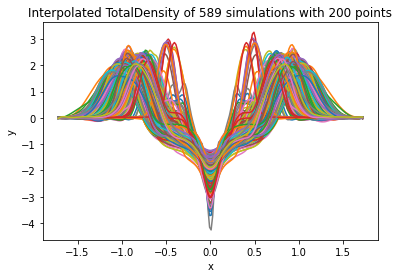

In [2]:
FF_df = pd.read_csv('form_factors.csv')
TD_x_df = pd.read_csv('gpr_total_density_x_200.csv')
TD_y_df = pd.read_csv('gpr_total_density_y_200.csv')

FF_df = FF_df.transpose()
TD_x_df = TD_x_df.transpose()
TD_y_df = TD_y_df.transpose()

for i in range(0,613):
    TD_y_df[i] = TD_y_df[i]-round((TD_y_df[i][0]+TD_y_df[i][199])/2,3)
    
FF_df = (FF_df-FF_df.mean())/FF_df.std()
TD_x_df = (TD_x_df-TD_x_df.mean())/TD_x_df.std()
TD_y_df = (TD_y_df-TD_y_df.mean())/TD_y_df.std()

outlier_column_indexes = set([])

index = 0
for value in TD_y_df.iloc[99]:
    if value > -1:
        outlier_column_indexes.add(index)
    index = index + 1

index = 0 
for value in TD_y_df.iloc[5]:
    if value > 0.30:
        outlier_column_indexes.add(index)
    index = index + 1
    
index = 0 
for value in TD_y_df.iloc[15]:
    if value > 0.30:
        outlier_column_indexes.add(index)
    index = index + 1
    
FF_df = FF_df.drop(outlier_column_indexes, axis=1)
TD_x_df = TD_x_df.drop(outlier_column_indexes, axis=1)
TD_y_df = TD_y_df.drop(outlier_column_indexes, axis=1)

for i in TD_y_df.columns:
    TD_y_df[i] = TD_y_df[i]-round((TD_y_df[i][0]+TD_y_df[i][199])/2,3)
    
i = 0
for index in TD_x_df.columns:
    plt.plot(TD_x_df[index],TD_y_df[index])
    i = i + 1
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interpolated TotalDensity of ' + str(i) + ' simulations with 200 points')
plt.show()

In [3]:
input_data = np.array(FF_df.iloc[: , :-14])
output_data_x = np.array(TD_x_df.iloc[: , :-14])
output_data_y = np.array(TD_y_df.iloc[: , :-14])
print(input_data.shape)
print(output_data_x.shape)
print(output_data_y.shape)

random.seed(42)
train = random.sample(range(0,input_data.shape[1]),int(input_data.shape[1]*0.8))
test = []
for number in range(0,input_data.shape[1]):
    if not number in train:
        test.append(number)

print(train)
print(len(train))
print(test)
print(len(test))

train_input_values = []
for number in train:
    train_input_values.append(input_data[:,number])
    
train_output_values = []
for number in train:
    train_output_values.append(np.concatenate((output_data_x[:,number],output_data_y[:,number])))

test_input_values = []
for number in test:
    test_input_values.append(input_data[:,number])
    
test_output_values = []
for number in test:
    test_output_values.append(np.concatenate((output_data_x[:,number],output_data_y[:,number])))
    
train_input_values = np.array(train_input_values).astype(np.float32)
train_output_values = np.array(train_output_values).astype(np.float32)
test_input_values = np.array(test_input_values).astype(np.float32)
test_output_values = np.array(test_output_values).astype(np.float32)

print(train_input_values.shape)
print(train_output_values.shape)
print(test_input_values.shape)
print(test_output_values.shape)

(1000, 575)
(200, 575)
(200, 575)
[114, 25, 281, 250, 228, 142, 104, 558, 89, 432, 32, 30, 95, 223, 238, 517, 27, 203, 429, 225, 459, 284, 6, 163, 565, 348, 553, 159, 220, 344, 568, 94, 389, 99, 367, 352, 270, 44, 470, 127, 387, 80, 300, 370, 196, 71, 46, 233, 296, 81, 560, 103, 542, 548, 464, 373, 166, 379, 363, 214, 273, 73, 175, 571, 83, 236, 194, 138, 506, 473, 327, 539, 285, 112, 350, 518, 431, 393, 397, 28, 117, 420, 16, 412, 161, 205, 137, 33, 108, 467, 482, 290, 448, 540, 490, 486, 335, 255, 202, 452, 468, 329, 234, 513, 135, 529, 126, 381, 287, 275, 134, 382, 299, 219, 554, 298, 204, 185, 501, 70, 260, 252, 528, 386, 24, 440, 56, 78, 321, 525, 405, 549, 216, 305, 564, 197, 195, 441, 239, 538, 128, 283, 5, 443, 369, 58, 349, 274, 384, 136, 497, 328, 174, 57, 150, 222, 533, 232, 1, 430, 368, 520, 256, 390, 91, 259, 54, 320, 152, 504, 409, 311, 101, 447, 191, 411, 82, 276, 271, 0, 306, 165, 511, 9, 421, 457, 157, 122, 29, 123, 483, 40, 43, 374, 248, 35, 272, 64, 65, 337, 243, 572

In [6]:
def single_average_loss(actual,prediction):
    length = int(actual.shape[0]/2)
    
    t_x = actual[0:length]
    t_y = actual[length:]
    p_x = prediction[0:length]
    p_y = prediction[length:]
    
    distance_sum = 0
    for i in range(0,length):
        distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)

    return (distance_sum/length)

def metrics(actual,prediction):
    amount = int(actual.shape[0])
    length = int(actual.shape[1]/2)
    
    index = 0
    loss_list = []
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        loss_list.append(distance_sum/length)
        index = index + 1
     
    average_loss = sum(loss_list)/amount
    mode_loss = Counter(np.round(loss_list,5)).most_common(10)
    median_loss = st.median(np.round(loss_list,5))
    
    plt.hist(np.round(loss_list,5), bins = amount)
    plt.xlabel('Loss')
    plt.ylabel('Amount')
    plt.title('Loss frequency for test data')
    plt.show()
    
    return [average_loss, mode_loss, median_loss]

def plots(actual,prediction):
    random.seed(42)
    train = random.sample(range(0,len(test_input_values)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x_1 = prediction[number][0:length]
        y_1 = prediction[number][length:]
        plt.plot(x_1,y_1,c='b')

        x_2 = test_output_values[number][0:length]
        y_2 = test_output_values[number][length:]
        plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random predictions |blue| against actual |red|')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b', label='Prediction', alpha=0.25)
        t_x = test_output_values[index][0:length].tolist()
        t_y = test_output_values[index][length:].tolist()
        plt.scatter(t_x,t_y,c='r', label = 'Actual', alpha=0.50)
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction |blue| and actual |red| data')
    plt.show()
    
    number = 10
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))
    
    number = 75
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))
    
    number = 80
    prediction = model.predict(test_input_values)
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show()
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))

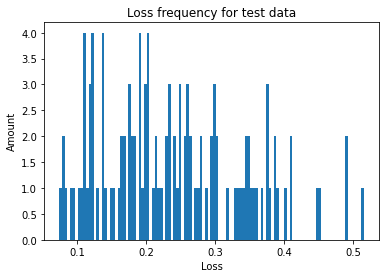

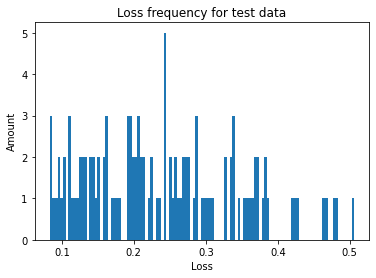

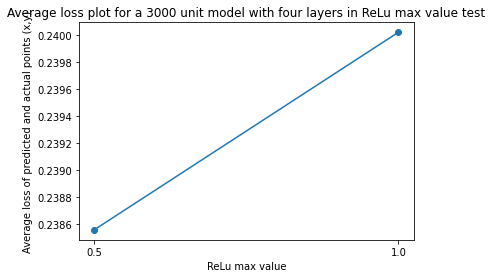

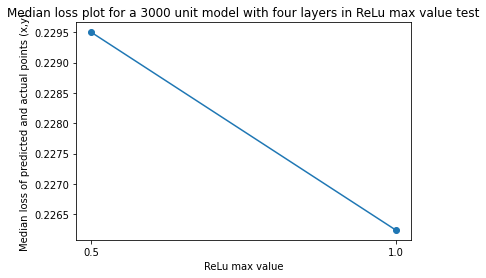

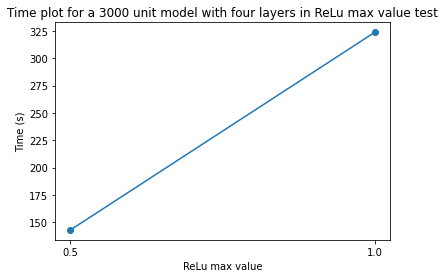

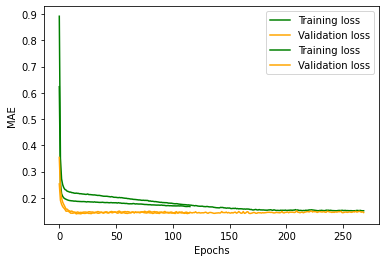


Used time: 468.2230877876282 seconds


In [7]:
def relu_max_value_testing(min_value, max_value, increment, train_input, train_output, test_input, test_output):
    general_start_time = time.time()
    
    max_values = np.round(np.arange(min_value, max_value + increment, increment),3)
    
    callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]
    
    training_losses = []
    training_val_losses = []
    loss_average_scores = []
    loss_median_scores = []
    times = []
    for used_max_value in max_values:
        run_start_time = time.time()
        
        inputs = keras.Input(shape=(1000,))
        x = layers.Dense(3000)(inputs)
        x = layers.ReLU(max_value = used_max_value, negative_slope=0, threshold=0)(x)
        x = layers.Dropout(0.1, seed=42)(x)
        x = layers.Dense(3000)(x)
        x = layers.ReLU(max_value = used_max_value, negative_slope=0, threshold=0)(x)
        x = layers.Dropout(0.1, seed=42)(x)
        x = layers.Dense(3000)(x)
        x = layers.ReLU(max_value = used_max_value, negative_slope=0, threshold=0)(x)
        x = layers.Dropout(0.1, seed=42)(x)
        x = layers.Dense(3000)(x)
        x = layers.ReLU(max_value = used_max_value, negative_slope=0, threshold=0)(x)
        x = layers.Dropout(0.1, seed=42)(x)
        outputs = layers.Dense(400)(x)
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam', loss='mean_absolute_error')
        
        history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
        results = metrics(test_output_values, model.predict(test_input_values))
        
        run_end_time = time.time()
        
        training_losses.append(history.history['loss'])
        training_val_losses.append(history.history['val_loss'])
        loss_average_scores.append(results[0])
        loss_median_scores.append(results[2])
        times.append(run_end_time - run_start_time)
         
    plt.plot(max_values,loss_average_scores, marker = 'o')
    plt.xticks(max_values, max_values)
    plt.xlabel('ReLu max value')
    plt.ylabel('Loss for points (x,y)')
    plt.title('Average loss plot for a 3000 unit model with four layers in ReLu max value test')
    plt.savefig('relu_max_value_testing_' + str(min_value) + '_' + str(max_value) + '_' + str(increment) + '.png')
    plt.show()
    
    plt.plot(max_values,loss_median_scores, marker = 'o')
    plt.xticks(max_values, max_values)
    plt.xlabel('ReLu max value')
    plt.ylabel('Loss for points (x,y)')
    plt.title('Median loss plot for a 3000 unit model with four layers in ReLu max value test')
    plt.savefig('relu_max_value_testing_' + str(min_value) + '_' + str(max_value) + '_' + str(increment) + '.png')
    plt.show()
    
    plt.plot(max_values,times, marker = 'o')
    plt.xticks(max_values, max_values)
    plt.xlabel('ReLu max value')
    plt.ylabel('Time (s)')
    plt.title('Time plot for a 3000 unit model with four layers in ReLu max value test')
    plt.savefig('relu_max_value_testing_' + str(min_value) + '_' + str(max_value) + '_' + str(increment) + '.png')
    plt.show()
    
    for i in range(0, len(training_losses)):
        plt.plot(training_losses[i], color = 'green', label = 'Training loss')
        plt.plot(training_val_losses[i], color = 'orange', label = 'Validation loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()
    
    general_end_time = time.time()
    print('')
    print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
    
relu_max_value_testing(0.25,10.0,0.25, train_input_values, train_output_values, test_input_values, test_output_values)

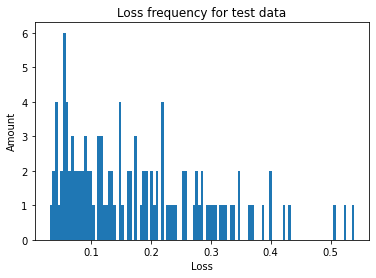

Loss average is: 0.17941669584483172
Loss mode is: [(0.08893, 1), (0.08939, 1), (0.10207, 1), (0.40093, 1), (0.16319, 1), (0.40023, 1), (0.14971, 1), (0.14898, 1), (0.32342, 1), (0.05129, 1)]
Loss median is: 0.14971
Used time: 19.183422327041626 seconds



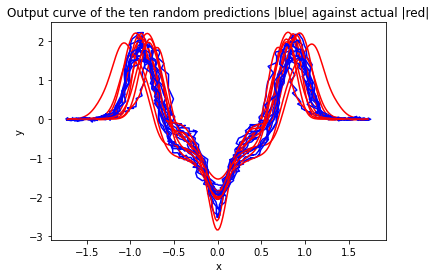

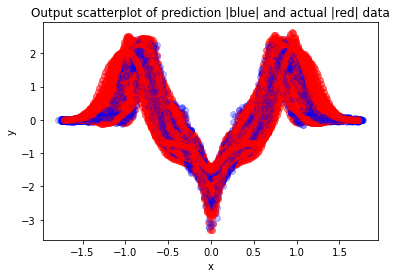

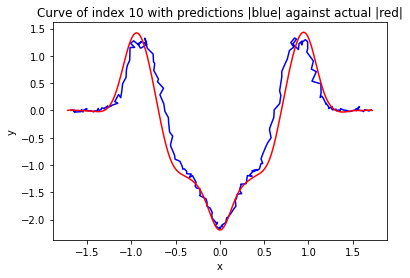

The loss of the curve 0.13889207761199296


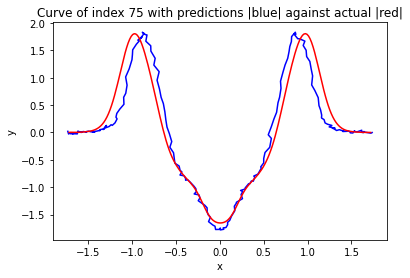

The loss of the curve 0.22019601681834405


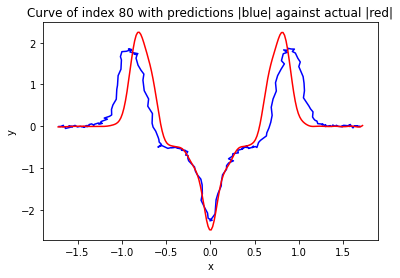

The loss of the curve 0.3370709601972672


In [13]:
#general_start_time = time.time()

#callbacks = [EarlyStopping(monitor='val_loss', 
#                       mode='min', 
#                       patience=100, 
#                       restore_best_weights=True)]

#inputs = keras.Input(shape=(1000,))
#x = layers.Dense(100, activation="elu")(inputs)
#x = layers.Dropout(0.1, seed=42)(x)
#x = layers.Dense(3000, activation="relu")(x)
#x = layers.Dropout(0.1, seed=42)(x)
#x = layers.Dense(3000, activation="relu")(x)
#x = layers.Dropout(0.1, seed=42)(x)
#x = layers.Dense(3000, activation="relu")(x)
#x = layers.Dropout(0.1, seed=42)(x)
#outputs = layers.Dense(400)(x)
#model = keras.Model(inputs=inputs, outputs=outputs)
#model.compile(optimizer='adam', loss='mean_absolute_error')

#model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
#results = metrics(test_output_values, model.predict(test_input_values))

#general_end_time = time.time()

#print('Loss average is: ' + str(results[0]))
#print('Loss mode is: ' + str(results[1]))
#print('Loss median is: ' + str(results[2]))
#print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
#print('')
#plots(test_output_values,model.predict(test_input_values))

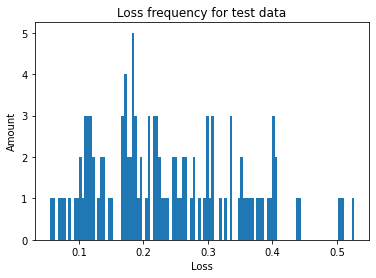

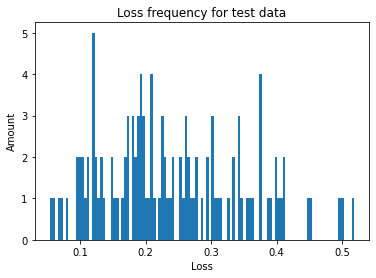

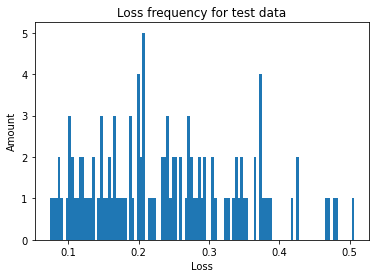

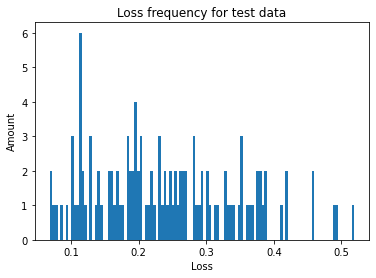

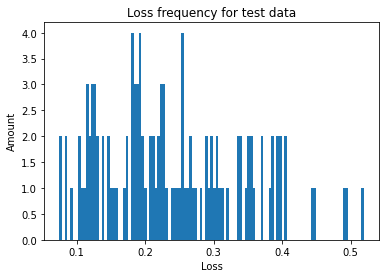

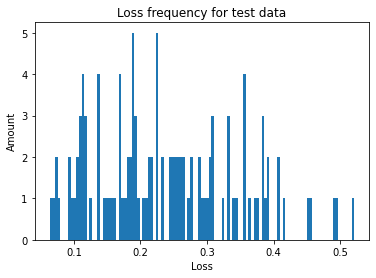

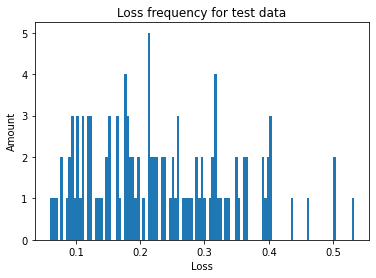

KeyboardInterrupt: 

In [8]:
relu_max_value_testing(0.25,10.0,0.25, train_input_values, train_output_values, test_input_values, test_output_values)

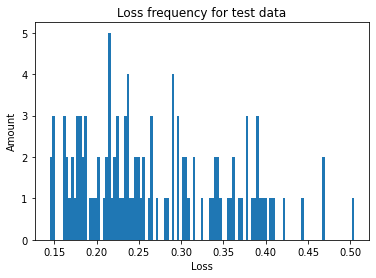

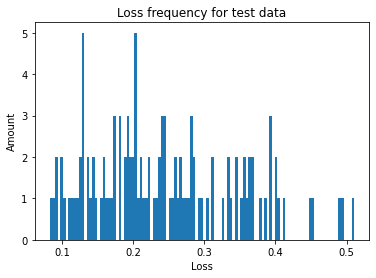

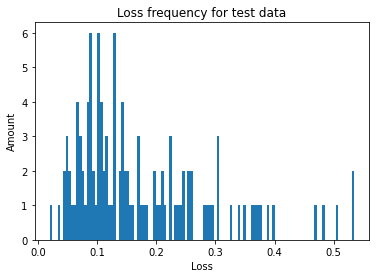

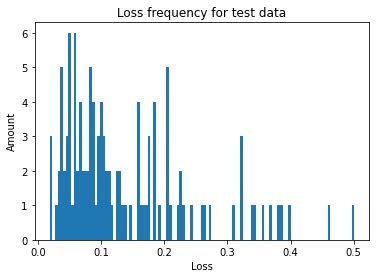

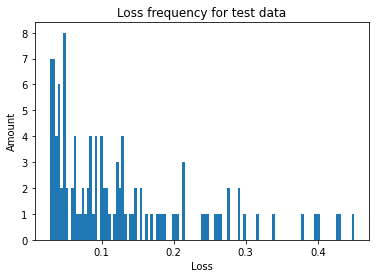

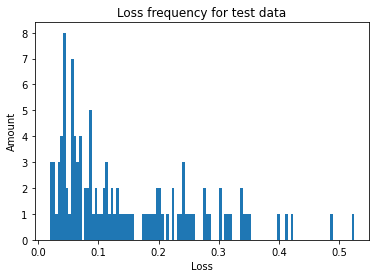

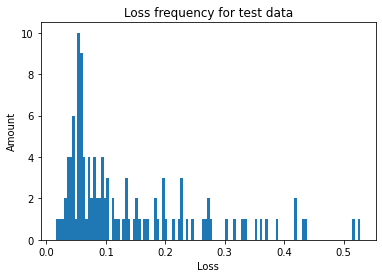

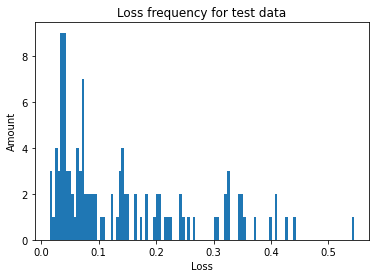

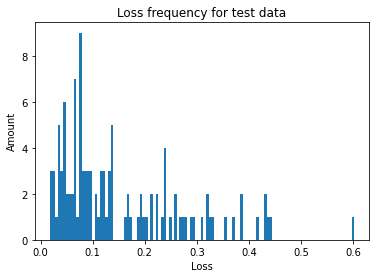

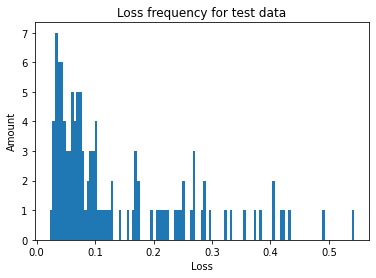

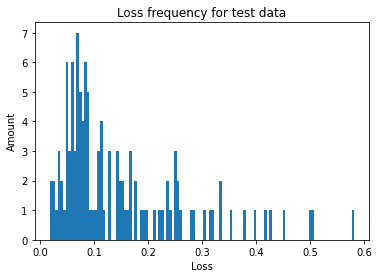

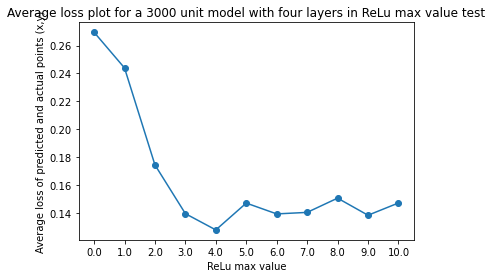

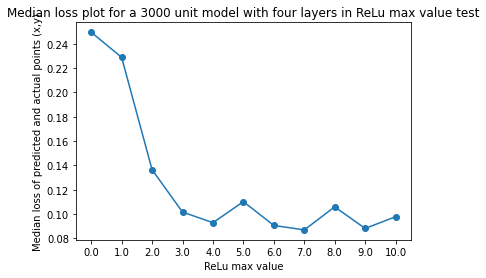

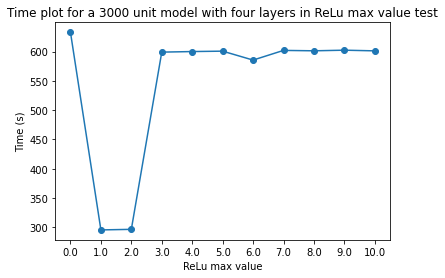

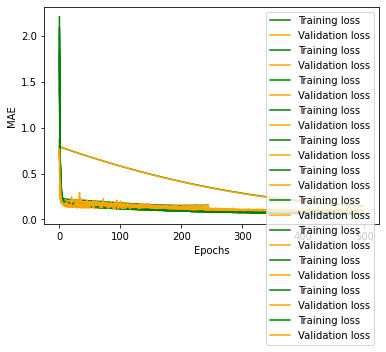


Used time: 6020.212403535843 seconds


In [9]:
relu_max_value_testing(0.00,10.0,1, train_input_values, train_output_values, test_input_values, test_output_values)